In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
import matplotlib as mpl
from scipy.interpolate import griddata
from tqdm import tqdm
%matplotlib inline

# Potential
We consider the non singular isothermal ellipsoid
$$
    \psi(\theta_1, \theta_2) = \sqrt{\frac{1}{1 - e}\theta_1^2 + (1 - e)\theta_2^2 + x_c}
$$
The perturbed potential will be rotated clockwise by $1^\circ$. 

The elements of the magnification matrix inverse for a spherical potential are
$$
    A^{-1}_{ij} \equiv \frac{\partial \vec{\beta}}{\partial \vec{\theta}} = \delta_{ij} -  \frac{\partial^2 \psi}{\partial \theta_i \partial \theta_j} = \delta_{ij} - \left(\frac{\delta_{ij} \psi^2 - \theta_i \theta_j}{\psi^3} \right)
$$

The critical curves are defined such that the inverse of the magnification $\mathcal{M}^{-1} = \det(A^{-1})$ is zero (leading to infinite magnification).

The time delay is given by
$$
    T(\vec{\theta}) = \frac{1}{2}(\vec{\theta} - \vec{\beta})^2 - \psi(\vec{\theta})
$$
where $\beta$ is the source coordinate frame given by
$$
    \vec{\beta}({\vec{\theta}}) = \vec{\theta} - \vec{\alpha}(\vec{\theta})
$$
$\alpha$ are deflection angles which are just
$$
    \vec{\alpha} = \vec{\nabla}\psi(\vec{\theta})
$$

In [25]:
e = 0.1 # modèle valide seulement pour e < 0.2
x_c = 0.1
def psi(theta1, theta2):
    return np.sqrt(1/(1 - e)*theta1**2 + (1 - e)*theta2**2 + x_c)

def grad_psi(theta1, theta2):
    p = psi(theta1, theta2)
    grad1 = theta1 / p / (1 - e)
    grad2 = (1 - e) * theta2 / p
    return grad1, grad2

def psi_11(theta1, theta2):
    p = psi(theta1, theta2)
    return (p**2/(1-e) - theta1**2/(1-e)**2)/p**3

def psi_22(theta1, theta2):
    p = psi(theta1, theta2)
    return ((1 - e) * p**2 - (1 - e)**2 * theta2**2)/p**3

def psi_12(theta1, theta2):
    return - theta1 * theta2 / psi(theta1, theta2)**3

def rotate(theta1, theta2, phi):
    rho = np.hypot(theta1, theta2)
    varphi = np.angle(theta1 + 1j*theta2) - phi
    rotated_theta1 = rho * np.cos(varphi)
    rotated_theta2 = rho * np.sin(varphi)
    return rotated_theta1, rotated_theta2

def inverse_mag_det(theta1, theta2):
    return (1 - psi_11(theta1, theta2)) * (1 - psi_22(theta1, theta2)) - psi_12(theta1, theta2)**2

def time_delay(theta1, theta2, x=0, y=0):
    return 0.5 * np.dot(theta1 - x, theta2 - y) - psi(theta1, theta2)
    

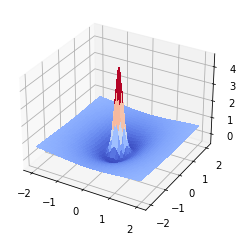

In [26]:
# image plane
N = 201
phi = np.deg2rad(1.1)

theta = np.linspace(-2, 2, N)
theta_x, theta_y = np.meshgrid(theta, theta)
theta_x, theta_y = rotate(theta_x, theta_y, phi)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(theta_x, theta_y, inverse_mag_det(theta_x, theta_y), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

(-2.0380263090426682,
 2.0380263090426682,
 -2.038026309042668,
 2.0380263090426687)

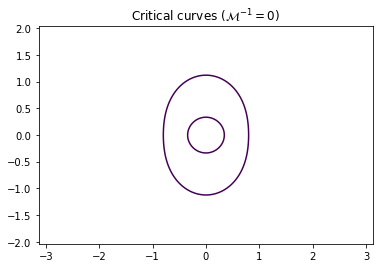

In [27]:
contour = plt.contour(theta_x, theta_y, inverse_mag_det(theta_x, theta_y), [0])
plt.title(r"Critical curves ($\mathcal{M}^{-1} = 0$)")
plt.axis("equal")

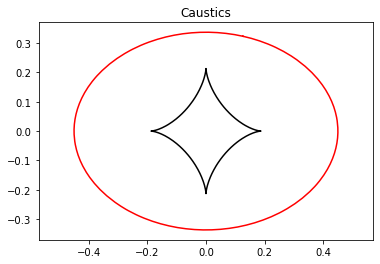

In [28]:
alpha_x, alpha_y = grad_psi(theta_x, theta_y)
critical_curve1 = contour.collections[0].get_paths()[0].vertices
critical_curve2 = contour.collections[0].get_paths()[1].vertices

cc11 = critical_curve1[:, 0]
cc12 = critical_curve1[:, 1]
thetas = np.column_stack([theta_x.ravel(), theta_y.ravel()])
alpha1_cc = griddata(thetas, alpha_x.ravel(), (cc11, cc12), method="cubic")
alpha2_cc = griddata(thetas, alpha_y.ravel(), (cc11, cc12), method="cubic")
caustic1_x = cc11 - alpha1_cc
caustic1_y = cc12 - alpha2_cc

cc21 = critical_curve2[:, 0]
cc22 = critical_curve2[:, 1]
thetas = np.column_stack([theta_x.ravel(), theta_y.ravel()])
alpha1_cc = griddata(thetas, alpha_x.ravel(), (cc21, cc22), method="cubic")
alpha2_cc = griddata(thetas, alpha_y.ravel(), (cc21, cc22), method="cubic")

caustic2_x = cc21 - alpha1_cc
caustic2_y = cc22 - alpha2_cc
# plt.plot(cc11, cc12, "k--", label="Critical curve 1")
# plt.plot(cc21, cc22, "r--", label="Critical curve 2")
plt.plot(caustic1_x, caustic1_y, "k-", label="Caustic 1")
plt.plot(caustic2_x, caustic2_y, "r-", label="Caustic 2")
# plt.legend()
plt.title("Caustics")
plt.axis("equal");

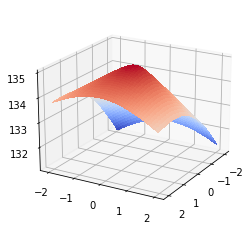

In [29]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(theta_x, theta_y, time_delay(theta_x, theta_y, x=0.3), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.view_init(20, 30)

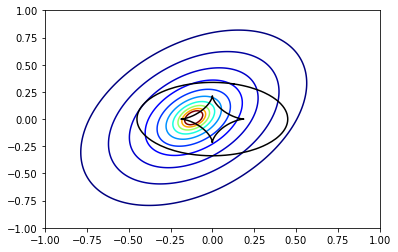

In [30]:
# make an elliptical source
beta1_0 = 0.1
beta2_0 = 0.05
elp = 0.634
phi = np.deg2rad(147.2)
beta_c = 2
I = 100
def source(beta1, beta2):
    beta1, beta2 = rotate(beta1, beta2, phi)
    return np.sqrt(beta_c) / np.hypot(beta1 - beta1_0, elp*(beta2 - beta2_0))

beta = np.linspace(-1, 1, N)
b1, b2 = np.meshgrid(beta, beta)
s = source(b1, b2)
M = 10
norm = mpl.colors.Normalize(vmin=0.,vmax=M)
cmap= cm.get_cmap("jet")
source_contours = plt.contour(b1, b2, s, levels=np.logspace(0.4, 1.5, M), cmap=cmap, linestyles="-")
plt.plot(caustic1_x, caustic1_y, "k-", label="Caustic 1")
plt.plot(caustic2_x, caustic2_y, "k-", label="Caustic 2")

100%|██████████| 10/10 [00:00<00:00, 48.76it/s]


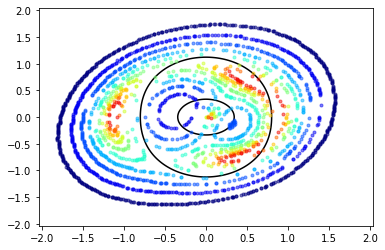

In [31]:
def betas_to_thetas(curve, alpha_x, alpha_y):
    c1 = curve[:, 0] # curve in beta space
    c2 = curve[:, 1]
    alphas = np.column_stack([alpha_x.ravel(), alpha_y.ravel()])
    betas = thetas - alphas # lens equation
    new_curve1 = griddata(betas, theta_x.ravel(), (c1, c2), method="nearest") # map from beta to theta
    new_curve2 = griddata(betas, theta_y.ravel(), (c1, c2), method="nearest")
    return new_curve1, new_curve2


for i, curve in enumerate(tqdm(source_contours.collections)):
    c = curve.get_paths()[0].vertices
    nc1, nc2 = betas_to_thetas(c, alpha_x, alpha_y)
    plt.plot(nc1, nc2, ".", color=cmap(norm(i)), alpha=0.5)
contour = plt.contour(theta_x, theta_y, inverse_mag_det(theta_x, theta_y), [0], colors="k")


# Model from Keeton 2001
$$
    \kappa(\xi) = \frac{1}{2}\frac{b^{2 - \alpha}}{(s^2 + \xi^2)^{1- \alpha/2}}
$$
Where
$$
    \xi^2 = x^2 + y^2/q^2
$$
and where $q$ is the axis ratio.

## Isothermal ellipsoid: $\alpha = 1$
$$
\begin{align}
    \phi(x, y) &= x\phi_x + y\phi_y - bqs \ln \left[(\psi + s)^2 + (1 - q^2)x^2 \right]^{1/2} + bqs \ln((1 + q)s) \\
    \phi_x(x, y) &= \frac{bq}{\sqrt{1 - q^2}} \tan^{-1} \left[\frac{x\sqrt{1 - q^2}}{\psi + s} \right] \\
    \phi_y(x, y) &= \frac{bq}{\sqrt{1 - q^2}} \tan^{-1} \left[\frac{y\sqrt{1 - q^2}}{\psi + q^2s} \right] \\
    \psi^2 &= q^2(s^2 + x^2) + y^2
\end{align}
$$

In [165]:
b = 5
s = 0.1
q = 0.5
def xi(x, y):
    return np.sqrt(x**2 + y**2/q**2)

def kappa(x, y):
    _xi = xi(x, y)
    return 0.5 * b / np.sqrt(s**2 + _xi**2)

def psi(x, y):
    return np.sqrt(q**2 * (s**2 + x**2) + y**2)

def phi_x(x, y):
    factor1 = b * q / np.sqrt(1 - q**2)
    factor2 = np.arctan(x * np.sqrt(1 - q**2) / (psi(x, y) + s))
    return factor1 * factor2

def phi_y(x, y):
    factor1 = b * q / np.sqrt(1 - q**2)
    factor2 = np.arctan(y * np.sqrt(1 - q**2) / (psi(x, y) + q**2 * s))
    return factor1 * factor2
    
def phi(x, y):
    term1 = x * phi_x(x, y) + y * phi_y(x, y)
    term2 = b * q * s * np.log(((psi(x, y) + s)**2 + (1 - q**2)*x**2)**(1/2))
    term3 = b * q * s * np.log((1 + q) * s)
    return term1 - term2 + term3

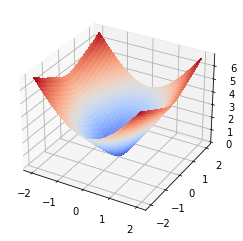

In [166]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(theta_x, theta_y, phi(theta_x, theta_y), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

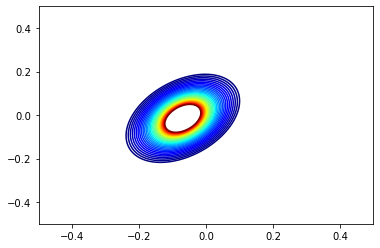

In [196]:
beta1_0 = 0.05
beta2_0 = 0.05
elp = 0.634
phi = np.deg2rad(147.2)
beta_c = 2
I = 100
def source(beta1, beta2):
    beta1, beta2 = rotate(beta1, beta2, phi)
    return np.sqrt(beta_c) / np.hypot(beta1 - beta1_0, elp*(beta2 - beta2_0))

beta = np.linspace(-0.5, 0.5, N)
b1, b2 = np.meshgrid(beta, beta)
s = source(b1, b2)
M = 30
norm = mpl.colors.Normalize(vmin=0.,vmax=M)
cmap= cm.get_cmap("jet")
source_contours = plt.contour(b1, b2, s, levels=np.logspace(1, 1.5, M), cmap=cmap, linestyles="-")

100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


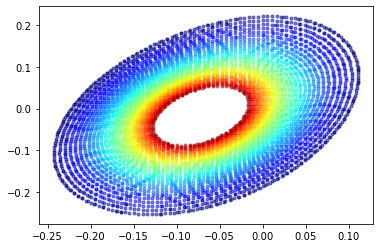

In [205]:
alpha_x = phi_x(theta_x, theta_y)
alpha_y = phi_y(theta_x, theta_y)
thetas = np.column_stack([theta_x.ravel(), theta_y.ravel()])
def betas_to_thetas(curve, alpha_x, alpha_y):
    c1 = curve[:, 0] # curve in beta space
    c2 = curve[:, 1]
    alphas = np.column_stack([alpha_x.ravel(), alpha_y.ravel()])
    betas = thetas - alphas # lens equation
    new_curve1 = griddata(betas, theta_x.ravel(), (c1, c2), method="linear") # map from beta to theta
    new_curve2 = griddata(betas, theta_y.ravel(), (c1, c2), method="linear")
    return new_curve1, new_curve2

for i, curve in enumerate(tqdm(source_contours.collections)):
    c = curve.get_paths()[0].vertices
    nc1, nc2 = betas_to_thetas(c, alpha_x, alpha_y)
    plt.plot(nc1, nc2, ".", color=cmap(norm(i)), alpha=0.5)

In [206]:
def plummer(x,y,modelargs):
    b,x0,y0,e,s  = modelargs
    
    x2 = x*x
    y2 = y*y
    s2 = s*s
    q  = 1.0-e
    q2 = q*q
    om = 1.0-q2
    rt = np.sqrt(om)
    front = b**3*q/s
    psi = np.sqrt(q2*(s2+x2)+y2)
    psi2 = psi*psi
    psi3 = psi2*psi
    
    invDenom = 1/(psi*(om+x2+(psi+s)**2))
    phix = front*x*(psi+s*q2)*invDenom
    phiy = front*y*(psi+s)   *invDenom
    
    tmp = (psi+s)**2+om*x2

    # phixx
    phixx = -2.0*front*x2*((psi+q2*s)/tmp)**2/psi2 + front*(psi2 *(psi+q2*s)-q2**2*x2*s)/(psi3*tmp)
    phiyy = -2.0*front*y2*((psi+   s)/tmp)**2/psi2 + front*(psi2 *(psi   +s)-      y2*s)/(psi3*tmp)
    phixy = -front*x*y*(2.0*(psi+s)*(psi+q2*s)/(psi2*tmp*tmp) + q2*s/(psi3*tmp))
    pot   = 0.5*front*np.log((psi+s)**2+om*x2) - front*np.log(s*(1.0+np.fabs(q)))
    
    return pot,phix,phiy,phixx,phiyy,phixy

args = (30, 0, 0, 1 - q, s)
pot,phix,phiy,phixx,phiyy,phixy = plummer(theta_x, theta_y, args)

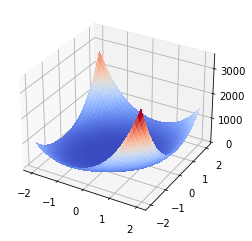

In [207]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(theta_x, theta_y, pot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

100%|██████████| 30/30 [00:14<00:00,  2.14it/s]


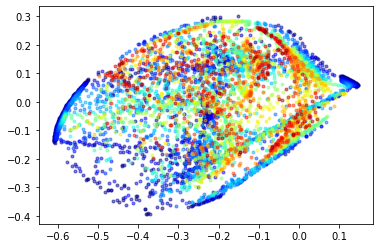

In [209]:
alpha_x = phix
alpha_y = phiy
def betas_to_thetas(curve, alpha_x, alpha_y):
    c1 = curve[:, 0] # curve in beta space
    c2 = curve[:, 1]
    alphas = np.column_stack([alpha_x.ravel(), alpha_y.ravel()])
    betas = thetas - alphas # lens equation
    new_curve1 = griddata(betas, theta_x.ravel(), (c1, c2), method="linear") # map from beta to theta
    new_curve2 = griddata(betas, theta_y.ravel(), (c1, c2), method="linear")
    return new_curve1, new_curve2

for i, curve in enumerate(tqdm(source_contours.collections)):
    c = curve.get_paths()[0].vertices
    nc1, nc2 = betas_to_thetas(c, alpha_x, alpha_y)
    plt.plot(nc1, nc2, ".", color=cmap(norm(i)), alpha=0.5)